# Classification of different Cell Types

### Loading all the libraries

In [160]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input

from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image


### Uploading the data and adding column for image path

In [151]:
data = pd.read_csv('data_labels_mainData.csv')
data['ImagePath'] = 'patch_images/' + data['ImageName'].astype(str)


### Checking the data

In [152]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImagePath
0,22405,1,22405.png,fibroblast,0,0,patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,patch_images/22409.png


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
 6   ImagePath     9896 non-null   object
dtypes: int64(4), object(3)
memory usage: 541.3+ KB


In [155]:
data.groupby('cellTypeName')['cellType'].value_counts()

cellTypeName  cellType
epithelial    2           4079
fibroblast    0           1888
inflammatory  1           2543
others        3           1386
Name: cellType, dtype: int64

<BarContainer object of 4 artists>

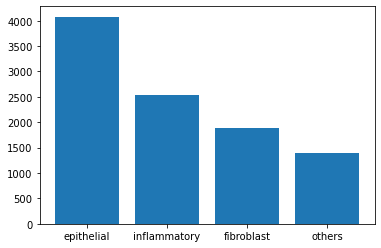

In [377]:
## Visualising the distribution of cell types 
x = data.cellTypeName.value_counts().index
y = data.cellTypeName.value_counts()
plt.bar(x, y)

### Splitting the data to train, validation, and test data

In [164]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42,stratify = data.patientID)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify = train_data.patientID)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


<BarContainer object of 4 artists>

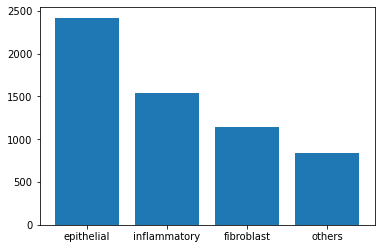

In [165]:
x = train_data.cellTypeName.value_counts().index
y = train_data.cellTypeName.value_counts()
plt.bar(x, y)

In [166]:
train_data.cellType.value_counts()

2    2419
1    1535
0    1148
3     835
Name: cellType, dtype: int64

### Visualising the image of each type of cell

In [167]:
uniqueCell_df = train_data.groupby('cellTypeName').first()

uniqueCell_df['index'] = range(1, len(uniqueCell_df) + 1)

In [168]:
uniqueCell_df = uniqueCell_df.reset_index()
uniqueCell_df

,cellTypeName,InstanceID,patientID,ImageName,cellType,isCancerous,ImagePath,index
0,epithelial,1005,49,1005.png,2,1,patch_images/1005.png,1
1,fibroblast,18594,4,18594.png,0,0,patch_images/18594.png,2
2,inflammatory,1554,60,1554.png,1,0,patch_images/1554.png,3
3,others,22402,58,22402.png,3,0,patch_images/22402.png,4


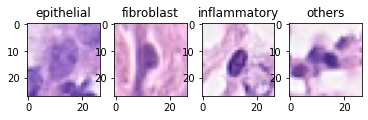

In [169]:
from PIL import Image

img_list = list(uniqueCell_df.ImagePath)
for i,rows in uniqueCell_df.iterrows():
    plt.subplot(1,4,rows['index'])
    img = Image.open(rows['ImagePath'])

    plt.imshow(img)
    plt.title(rows['cellTypeName'])
    

### Dimensions of Image

In [170]:
img = Image.open(img_list[1])
img_numpy = np.ascontiguousarray(img, dtype = np.float32)
print("image size \nH{} W{} C{}".format(img_numpy.shape[0],img_numpy.shape[1],img_numpy.shape[2]))

image size 
H27 W27 C3


In [171]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Implementing the basic MLP

In [172]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256

OUTPUT_CLASSES = 4

In [173]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.3.0'

In [194]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [195]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [196]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [200]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [201]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

## Data Generators for train, validation and test data

In [211]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 64

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [222]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

<ipython-input-222-c13c9290043f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


Found 1980 validated image filenames belonging to 4 classes.


In [212]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

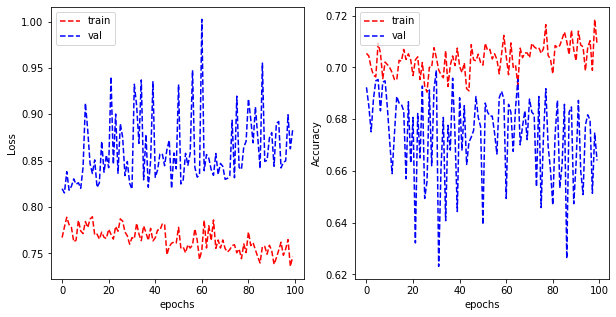

In [213]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

We see that there is overfitting and hence we try to improve the model by implementing better models in CNN

In [214]:
model.evaluate(train_generator)

93/93 [==============================] - 5s 55ms/step - loss: 0.7457 - categorical_accuracy: 0.7148


[0.7457254528999329, 0.7148391604423523]

In [215]:
model.evaluate(validation_generator)

31/31 [==============================] - 1s 45ms/step - loss: 0.8835 - categorical_accuracy: 0.6640


[0.8835017681121826, 0.6639717221260071]

In [217]:
model.evaluate(test_generator)

1980/1980 [==============================] - 3s 1ms/step - loss: 0.8620 - categorical_accuracy: 0.6707


[0.8619992733001709, 0.6707070469856262]

In [218]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

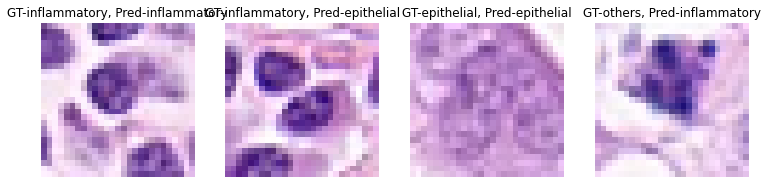

In [219]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## Implementing CNN

In [337]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [338]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


<ipython-input-338-c13c9290043f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


## Plotting the curve

In [224]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Default Baseline Model

In [228]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [229]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [230]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

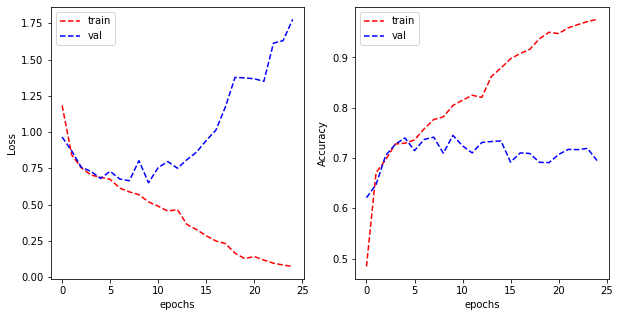

In [231]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [232]:
model_VGG_1.evaluate(test_generator)

1980/1980 [==============================] - 6s 3ms/step - loss: 1.7307 - categorical_accuracy: 0.7106


[1.730705976486206, 0.710606038570404]

In [233]:
model_VGG_1.evaluate(validation_generator)

62/62 [==============================] - 2s 25ms/step - loss: 1.7768 - categorical_accuracy: 0.6948


[1.776798963546753, 0.6947953701019287]

In [234]:
model_VGG_1.evaluate(train_generator) 

186/186 [==============================] - 6s 33ms/step - loss: 0.0268 - categorical_accuracy: 0.9921


[0.02683039754629135, 0.9920835494995117]

We again see that there is overfitting in he model. As we see from the graph as well as the evaluated accuracy which says trains gives a score of 99% and Validation a score of 69. Hence we try to improve the model.

## Make incremental Changes using VGG regularisation

In [339]:
def build_model(reg_lambda, learning_rate, dense_layer):
    
    model = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_layer, activation='relu'),
        #tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
    model_history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

    plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Performance on test data: ", str(model.evaluate(test_generator)))
        
    return model

Training for reg_lamda = 0.001 , learning_rate= 0.001 , Neurons in dense layer= 128


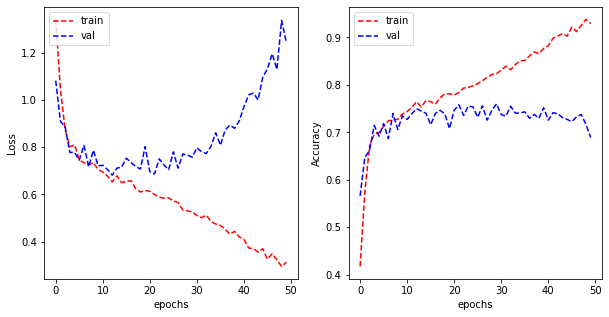

1980/1980 [==============================] - 6s 3ms/step - loss: 1.2777 - categorical_accuracy: 0.7162
Performance on test data:  [1.2776786088943481, 0.7161616086959839]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.001 , Neurons in dense layer= 256


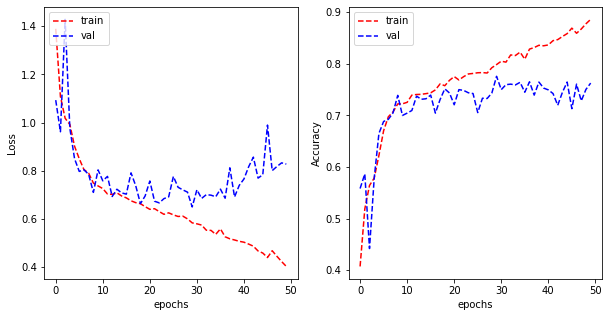

1980/1980 [==============================] - 6s 3ms/step - loss: 0.8372 - categorical_accuracy: 0.7758
Performance on test data:  [0.8372098803520203, 0.7757575511932373]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.01 , Neurons in dense layer= 128


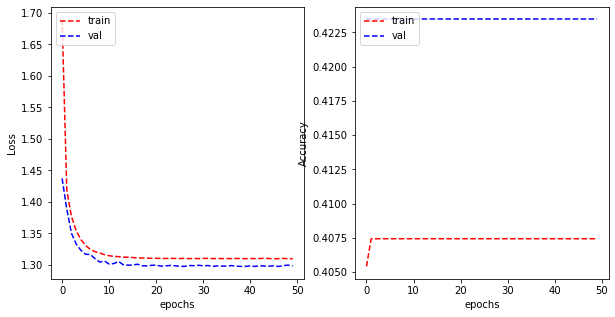

1980/1980 [==============================] - 5s 2ms/step - loss: 1.3040 - categorical_accuracy: 0.4152
Performance on test data:  [1.3040012121200562, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.01 , Neurons in dense layer= 256


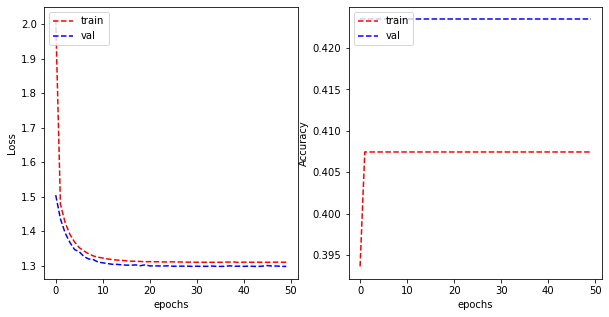

1980/1980 [==============================] - 7s 3ms/step - loss: 1.3039 - categorical_accuracy: 0.4152
Performance on test data:  [1.3038986921310425, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.001 , Neurons in dense layer= 128


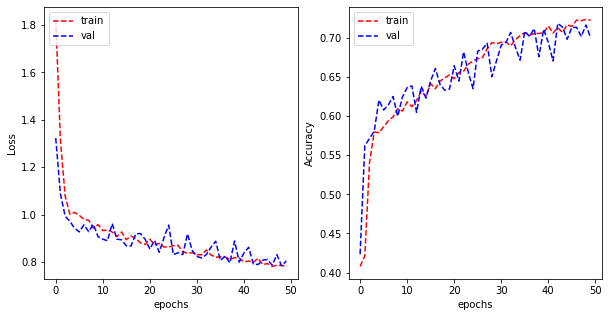

1980/1980 [==============================] - 6s 3ms/step - loss: 0.7898 - categorical_accuracy: 0.7283
Performance on test data:  [0.7897639274597168, 0.7282828092575073]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.001 , Neurons in dense layer= 256


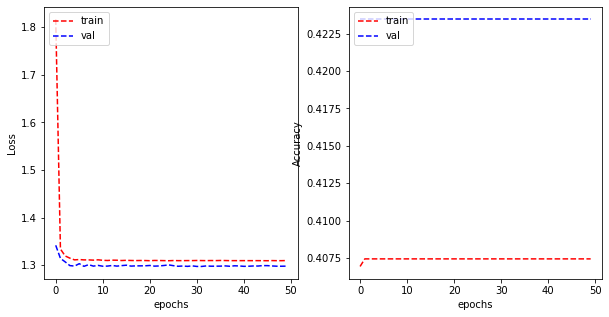

1980/1980 [==============================] - 7s 3ms/step - loss: 1.3040 - categorical_accuracy: 0.4152
Performance on test data:  [1.3039989471435547, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.01 , Neurons in dense layer= 128


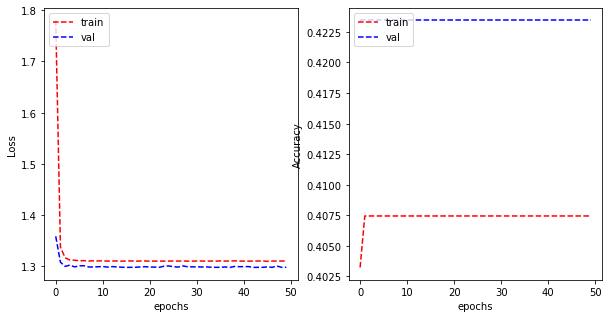

1980/1980 [==============================] - 6s 3ms/step - loss: 1.3040 - categorical_accuracy: 0.4152
Performance on test data:  [1.3040142059326172, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.01 , Neurons in dense layer= 256


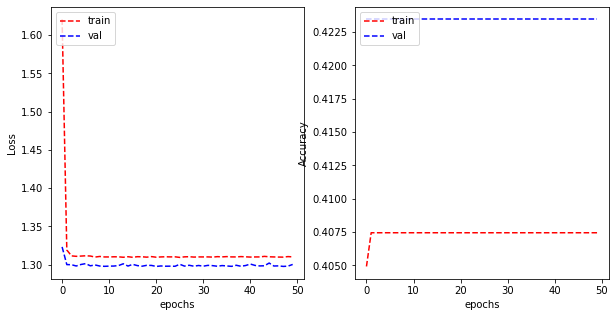

1980/1980 [==============================] - 2s 1ms/step - loss: 1.3054 - categorical_accuracy: 0.4152
Performance on test data:  [1.305375576019287, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.001 , Neurons in dense layer= 128


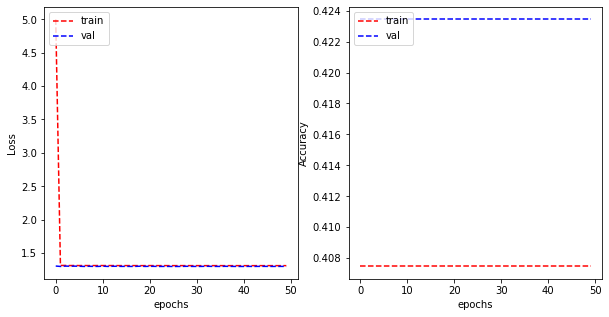

1980/1980 [==============================] - 2s 1ms/step - loss: 1.3039 - categorical_accuracy: 0.4152
Performance on test data:  [1.3039400577545166, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.001 , Neurons in dense layer= 256


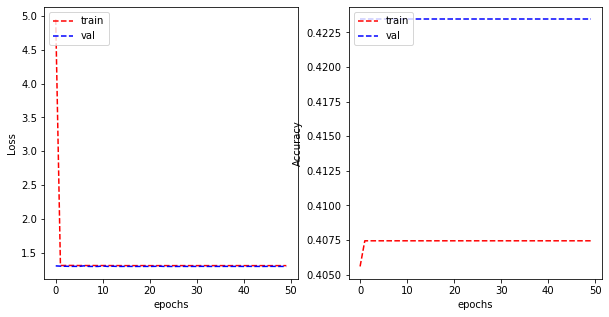

1980/1980 [==============================] - 3s 1ms/step - loss: 1.3039 - categorical_accuracy: 0.4152
Performance on test data:  [1.3038684129714966, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.01 , Neurons in dense layer= 128


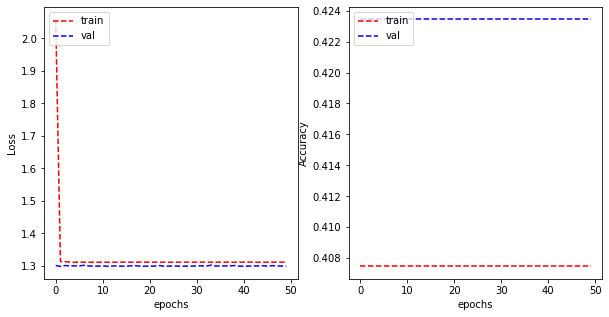

1980/1980 [==============================] - 2s 1ms/step - loss: 1.3044 - categorical_accuracy: 0.4152
Performance on test data:  [1.3043947219848633, 0.4151515066623688]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.01 , Neurons in dense layer= 256


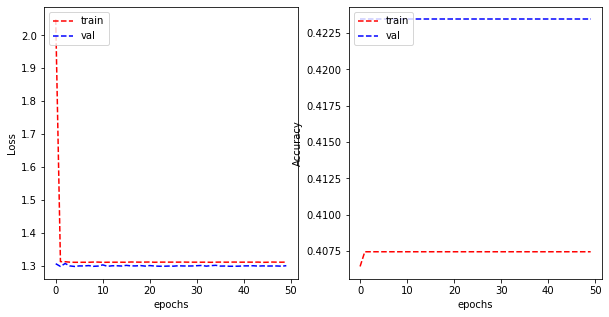

1980/1980 [==============================] - 3s 1ms/step - loss: 1.3055 - categorical_accuracy: 0.4152
Performance on test data:  [1.3054677248001099, 0.4151515066623688]
* End of iteration *



In [236]:
reg_lambda = [0.001, 0.01, 0.1]
learning_rate = [0.001, 0.01]
dense_layer = [128, 256]

for reg in reg_lambda:
    for lr in learning_rate:
        for dl in dense_layer:
            print("Training for reg_lamda =",reg,", learning_rate=",lr,", Neurons in dense layer=",dl)
                
            build_model(reg, lr, dl)
        
            print("* End of iteration *")
            
            print()

We explore the CNN with multiple parameters by implementing regularization and choose the best parameters where we get the best fit model

### We see that we get the best fit at lambda= 0.01 and learning rate 0.001. Now we try to improve the model by increasing the epoch.

In [342]:
reg_lambda = 0.01

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [343]:

model_VGG_2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

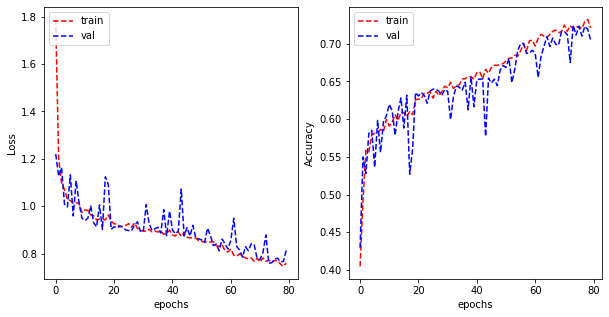

In [344]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=80, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [345]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 3s 1ms/step - loss: 0.7872 - categorical_accuracy: 0.7273


[0.7872357368469238, 0.7272727489471436]

In [346]:
model_VGG_2.evaluate(validation_generator)

62/62 [==============================] - 1s 15ms/step - loss: 0.8151 - categorical_accuracy: 0.7044 0s - loss: 0.8098 - categorical_accuracy: 0.


[0.8150896430015564, 0.7043961882591248]

In [347]:
model_VGG_2.evaluate(train_generator)

186/186 [==============================] - 3s 15ms/step - loss: 0.7810 - categorical_accuracy: 0.7206


[0.7810042500495911, 0.720565915107727]

### Checking the performance scores

In [348]:
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_VGG_2.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Precision Score: ", precision_score(y_all, y_hat_all, average="macro"))
print("Recall Score: ", recall_score(y_all,y_hat_all, average="macro"))
#print("ROC-AUC Score: ", roc_auc_score(y_all,y_hat_all, average="macro"))

print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.7272727272727273
F1 score:  0.6514601565527195
Precision Score:  0.6982093683290103
Recall Score:  0.6579245004533041
[[251  69  27  27]
 [ 30 449  13  15]
 [ 51 103 667   1]
 [ 58 129  17  73]]


We see that the above model is the best fit model hat we get as we see from the curves that there is very less gap between the validation vurve and train data curve which shows it doesnt have a significant overfitting

#### Data Augmentation performed in the other ipynb 

#### Here we increase the epochs to 200 and see that after a point the validation curves remains stagnent and does not learns any further

In [255]:
reg_lambda = 0.01

model_VGG_4 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [256]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model_VGG_4.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

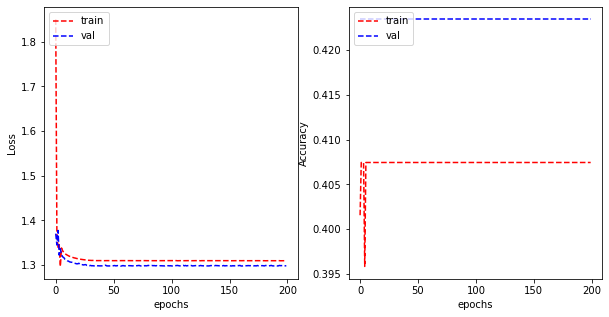

In [257]:
history_VGG_4 = model_VGG_4.fit_generator(train_generator, validation_data = validation_generator, epochs=200, verbose=0)

plot_learning_curve(history_VGG_4.history['loss'], history_VGG_4.history['val_loss'], 
                    history_VGG_4.history['categorical_accuracy'], history_VGG_4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### We apply and see if batch normalization helps to improve the model

In [140]:
reg_lambda = 0.01

model_VGG_5 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [141]:
model_VGG_5.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping


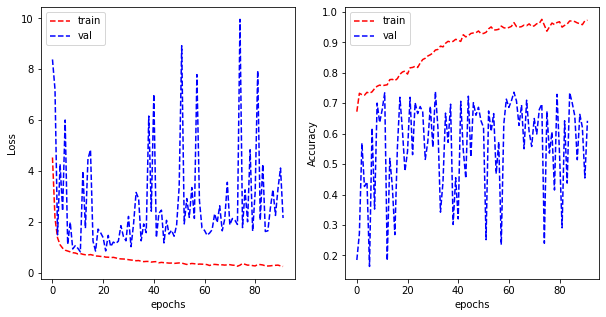

In [142]:

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=80,verbose=1,restore_best_weights=True)

history_VGG_5 = model_VGG_5.fit_generator(train_generator, validation_data = validation_generator,callbacks =[monitor], epochs=200, verbose=0)

plot_learning_curve(history_VGG_5.history['loss'], history_VGG_5.history['val_loss'], 
                    history_VGG_5.history['categorical_accuracy'], history_VGG_5.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

#### Even batch normalization doesnt help much to improve the model and hence we select vgg2 as our best model and use this to predict the unseen data and try implementing it on extra data

### Using Extra Data

We observe that there has been an imbalance between the classes and we have tried to balance the weights using class weight balancing technique using the function, but it was not successfull as desired. 

Hence we make use of the extra dataset to predict the cell types from the images given and then we will oversample the celltype which has the least count or images in the main dataset and hence trying to reduce the class imbalance in the dataset. 

##### Note: We note that we dont use the entire predicted data into the train data as this would widen the class imbalance and would result in poor model performace

#### Reading the extra dataset

In [350]:
xtra_Data = pd.read_csv('data_labels_extraData.csv')
xtra_Data['ImagePath'] = 'patch_images/' + xtra_Data['ImageName'].astype(str)

#### Implementing the best vgg model that we got to predict the celltypes of the images in the extra dataset

In [351]:
Predicted_cellType = []
Predicted_cellTypeName = []
image_list = xtra_Data.ImagePath.tolist()

for img in image_list:

    img = image.load_img(img, target_size=(27, 27))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    classes = model_VGG_2.predict_classes(img)
    Predicted_cellType.append(classes[0])


In [352]:
xtra_Data['cellType'] = Predicted_cellType


In [353]:
xtra_Data['cellType'] = xtra_Data['cellType'].astype('str')


In [354]:
xtra_Data.head()

,InstanceID,patientID,ImageName,isCancerous,ImagePath,cellType
0,12681,61,12681.png,0,patch_images/12681.png,1
1,12682,61,12682.png,0,patch_images/12682.png,0
2,12683,61,12683.png,0,patch_images/12683.png,1
3,12684,61,12684.png,0,patch_images/12684.png,0
4,12685,61,12685.png,0,patch_images/12685.png,0


In [355]:
xtra_Data.shape

(10384, 6)

In [356]:
xtra_Data.cellType.value_counts()

2    5021
1    4109
0    1223
3      31
Name: cellType, dtype: int64

In the main dataset we see that the celltype 3 has the least no. of images and hence we try to increase the number of images in celltypes 3 by adding it from the extra data that is predicted

In [357]:
newData = train_data.append(xtra_Data[xtra_Data.cellType == '3'])

In [358]:
newData.shape

(5968, 7)

<BarContainer object of 4 artists>

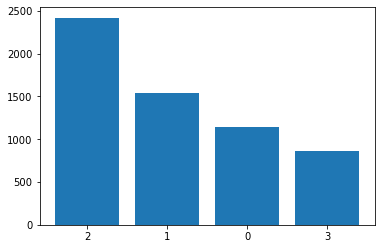

In [359]:
## Visualising the distribution of cell types 
x = newData.cellType.value_counts().index
y = newData.cellType.value_counts()
plt.bar(x, y)

### Creating data generators with the new train Data

In [360]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 64

train_generator = train_datagen.flow_from_dataframe(
        dataframe=newData,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5968 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [361]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


<ipython-input-361-c13c9290043f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


### Implementing the best model that we have

In [362]:
reg_lambda = 0.01

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [363]:

model_VGG_2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

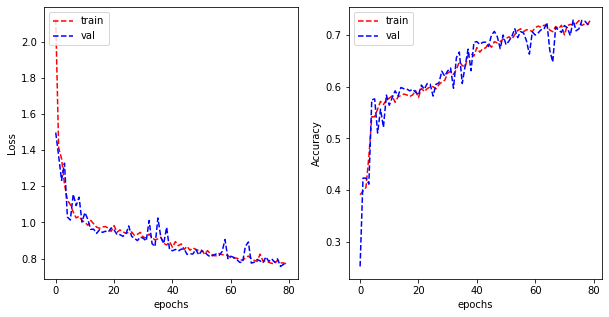

In [364]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=80, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

#### We see from above that there is approx no overfitting and is a good fit

In [367]:
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_VGG_2.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Precision Score: ", precision_score(y_all, y_hat_all, average="macro"))
print("Recall Score: ", recall_score(y_all,y_hat_all, average="macro"))
#print("ROC-AUC Score: ", roc_auc_score(y_all,y_hat_all, average="macro"))

print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.7348484848484849
F1 score:  0.6447096054324329
Precision Score:  0.7033362759266901
Recall Score:  0.6383859091110333
[[203  80  59  32]
 [ 25 414  56  12]
 [ 10  47 765   0]
 [ 37 130  37  73]]


#### We see that there was not much increase in the accuracy score and F1 score from the model that was build before appending the predicted data. This could be because the celltype 3 that was predicted was just 30 and addition of just 30 more images hasnt made a huge impact.